# Team members
- Bryce Grahn
- Michael Rolle
- Werner de jager
- Abdul Gany Osman
- Lavania Naidoo

# Introduction
The aim of this notebook is undertaking a machine learning investigation on the....

# 1. Imports and installations

In [79]:
#PIP
!pip install plotly
!pip install sweetviz

In [112]:

# imports
import os
import math
import calendar
import numpy as np
import scipy as sp
import pandas as pd
import sympy as sym
import seaborn as sns
import sklearn as sk
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import matplotlib.pyplot as plt
import sweetviz as sw

from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import  confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# define plt settings 
plt.rcParams["font.size"] = 20 
plt.rcParams["axes.labelsize"] = 20 
plt.rcParams["xtick.labelsize"] = 20 
plt.rcParams["ytick.labelsize"] = 20 
plt.rcParams["legend.fontsize"] = 20 
plt.rcParams["figure.figsize"] = (20,10)

# define seaborn settings seaborn
sns.set(style="ticks", color_codes=True)
sns.set_palette("husl")

## Import Dataset

In [81]:
url = '/kaggle/input/payments-hackathon-rojones/Payments Fraud DataSet/'

customers_df = pd.read_csv(url + "customers.csv", index_col = 'CUSTOMER_ID')
terminals_df = pd.read_csv(url + "terminals.csv", index_col = 'TERMINAL_ID')
merchants_df = pd.read_csv(url + "merchants.csv", index_col = 'MERCHANT_ID')
transactions_test_df = pd.read_csv(url + "transactions_test.csv", index_col = 'TX_ID')


# Remove last row in the train dataset to resolve multiple type issue in IS_RECURRING_TRANSACTION column
transactions_train_df = pd.read_csv(url + "transactions_train.csv", index_col = 'TX_ID', dtype={'IS_RECURRING_TRANSACTION': str})
transactions_train_df = transactions_train_df[transactions_train_df['IS_RECURRING_TRANSACTION'] != 'Fals']
transactions_train_copy = transactions_train_df
transactions_train_df['IS_RECURRING_TRANSACTION'] = transactions_train_df['IS_RECURRING_TRANSACTION'].astype(bool)

# 2. Understand Data

In [82]:
print("Customers dataset:")
print("----------------------")
display(customers_df.info())
print("\nterminals dataset:")
print("----------------------")
display(terminals_df.info())
print("\nmerchants dataset:")
print("----------------------")
display(merchants_df.info())
print("\ntransactions_test dataset:")
print("----------------------")
display(transactions_test_df.info())
print("\ntransactions_train dataset:")
print("----------------------")
display(transactions_train_df.info())
print("\ninput dataset:")
print("----------------------")

Customers dataset:
----------------------
<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 7894622031164826 to 5987355644780185
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   x_customer_id  50000 non-null  float64
 1   y_customer_id  50000 non-null  float64
dtypes: float64(2)
memory usage: 1.1 MB


None


terminals dataset:
----------------------
<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 9754224 to 14982407
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   x_terminal_id   5000 non-null   float64
 1   y_terminal__id  5000 non-null   float64
dtypes: float64(2)
memory usage: 117.2 KB


None


merchants dataset:
----------------------
<class 'pandas.core.frame.DataFrame'>
Index: 30452 entries, 1b7557bb-208b-4fdc-ba91-eca98298541a to cb5826ba-6a40-4f7f-9b53-ae7f3e35e740
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   BUSINESS_TYPE                       30452 non-null  object
 1   MCC_CODE                            30452 non-null  int64 
 2   LEGAL_NAME                          30452 non-null  object
 3   FOUNDATION_DATE                     30452 non-null  object
 4   TAX_EXCEMPT_INDICATOR               30452 non-null  bool  
 5   OUTLET_TYPE                         30452 non-null  object
 6   ACTIVE_FROM                         30452 non-null  object
 7   TRADING_FROM                        30452 non-null  object
 8   ANNUAL_TURNOVER_CARD                30452 non-null  int64 
 9   ANNUAL_TURNOVER                     30452 non-null  int64 
 10  AVERAGE_TICKET

None


transactions_test dataset:
----------------------
<class 'pandas.core.frame.DataFrame'>
Index: 71139 entries, 09324d812ba7915c3f791e973db293ad50db70d8 to 4af7a6f698e30cecc97ac5254315c97db971bf56
Data columns (total 20 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   TX_TS                                  71139 non-null  object 
 1   CUSTOMER_ID                            71139 non-null  int64  
 2   TERMINAL_ID                            71139 non-null  int64  
 3   TX_AMOUNT                              71139 non-null  float64
 4   TRANSACTION_GOODS_AND_SERVICES_AMOUNT  71139 non-null  float64
 5   TRANSACTION_CASHBACK_AMOUNT            71139 non-null  float64
 6   CARD_EXPIRY_DATE                       71139 non-null  object 
 7   CARD_DATA                              71139 non-null  object 
 8   CARD_BRAND                             71139 non-null  object 
 9   TRANSACTION_TYPE  

None


transactions_train dataset:
----------------------
<class 'pandas.core.frame.DataFrame'>
Index: 1066439 entries, c6dde46458f3d1cfeb9256f8add45a14fb349f8f to 6a7b367a598cc256317843cace0742b3e49d7780
Data columns (total 20 columns):
 #   Column                                 Non-Null Count    Dtype  
---  ------                                 --------------    -----  
 0   TX_TS                                  1066439 non-null  object 
 1   CUSTOMER_ID                            1066439 non-null  int64  
 2   TERMINAL_ID                            1066439 non-null  int64  
 3   TX_AMOUNT                              1066439 non-null  float64
 4   TX_FRAUD                               1066439 non-null  int64  
 5   TRANSACTION_GOODS_AND_SERVICES_AMOUNT  1066439 non-null  float64
 6   TRANSACTION_CASHBACK_AMOUNT            1066439 non-null  float64
 7   CARD_EXPIRY_DATE                       1066439 non-null  object 
 8   CARD_DATA                              1066439 non-null  object

None


input dataset:
----------------------


In [83]:
print("Customers dataset:")
print("----------------------")
display(customers_df.head())
print("\nterminals dataset:")
print("----------------------")
display(terminals_df.head())
print("\nmerchants dataset:")
print("----------------------")
display(merchants_df.head())
print("\ntransactions_test dataset:")
print("----------------------")
display(transactions_test_df.head())
print("\ntransactions_train dataset:")
print("----------------------")
display(transactions_train_df.head())

Customers dataset:
----------------------


,x_customer_id,y_customer_id
CUSTOMER_ID,,
7894622031164826,7.600289,92.486016
65009550197454,97.647808,36.539666
5381378528001886,98.643812,46.537793
344044685095332,2.814298,57.194127
5281794686066290,49.174496,88.879290



terminals dataset:
----------------------


,x_terminal_id,y_terminal__id
TERMINAL_ID,,
9754224,41.536730,68.889911
37467861,61.864075,20.882662
20678215,70.530677,36.567633
12724021,92.961874,66.721471
2989793,38.756717,68.669003



merchants dataset:
----------------------


,BUSINESS_TYPE,MCC_CODE,LEGAL_NAME,FOUNDATION_DATE,TAX_EXCEMPT_INDICATOR,OUTLET_TYPE,ACTIVE_FROM,TRADING_FROM,ANNUAL_TURNOVER_CARD,ANNUAL_TURNOVER,AVERAGE_TICKET_SALE_AMOUNT,PAYMENT_PERCENTAGE_FACE_TO_FACE,PAYMENT_PERCENTAGE_ECOM,PAYMENT_PERCENTAGE_MOTO,DEPOSIT_REQUIRED_PERCENTAGE,DEPOSIT_PERCENTAGE,DELIVERY_SAME_DAYS_PERCENTAGE,DELIVERY_WEEK_ONE_PERCENTAGE,DELIVERY_WEEK_TWO_PERCENTAGE,DELIVERY_OVER_TWO_WEEKS_PERCENTAGE
MERCHANT_ID,,,,,,,,,,,,,,,,,,,,
1b7557bb-208b-4fdc-ba91-eca98298541a,Corporations,1711,14b61a,2012-01-11,False,Ecommerce,2012-02-02,2012-02-06,197030527,351840227,550,49,51,0,0,0,26,25,28,21
6c948718-ea18-4d07-85d7-0916eb55e699,Corporations,5511,05047b,2013-03-17,False,Ecommerce,2013-04-06,2013-04-12,411017547,411017547,36326,50,50,0,0,0,22,28,25,25
f0151a49-7ac0-4258-93db-46bee2db6f66,Corporations,5971,e3c9e5,2019-03-03,False,Ecommerce,2019-03-06,2019-03-15,196408214,306887834,546,54,46,0,0,0,29,28,23,20
07089d03-0d63-4d24-a3f9-e651fda07cdc,Corporations,7629,940e26,2011-05-31,False,Ecommerce,2011-06-23,2011-07-03,603864188,686209305,657,57,43,0,0,0,22,27,26,25
2c16629a-da48-4e69-9862-8fd521a53bbc,Corporations,8398,bd9404,2019-03-26,False,Ecommerce,2019-04-14,2019-04-23,384701644,384701644,541,62,33,5,0,0,24,20,26,30



transactions_test dataset:
----------------------


,TX_TS,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TRANSACTION_GOODS_AND_SERVICES_AMOUNT,TRANSACTION_CASHBACK_AMOUNT,CARD_EXPIRY_DATE,CARD_DATA,CARD_BRAND,TRANSACTION_TYPE,TRANSACTION_STATUS,FAILURE_CODE,FAILURE_REASON,TRANSACTION_CURRENCY,CARD_COUNTRY_CODE,MERCHANT_ID,IS_RECURRING_TRANSACTION,ACQUIRER_ID,CARDHOLDER_AUTH_METHOD,ID_JOIN
TX_ID,,,,,,,,,,,,,,,,,,,,
09324d812ba7915c3f791e973db293ad50db70d8,2021-12-03 22:04:58+00:00,4635360198955981,4641801,34.61,34.61,0.0,05/23,3409********496,AMEX,Purchase,Settled,NaN,NaN,USD,US,52f53dfb-6f2c-4584-8c82-aeafbcd7a02d,False,ACQ2,Signature,5637.0
a17bc798bacadbde6cd7928688e2453fa6023d67,2021-12-03 05:32:09+00:00,3695434572951846,75652463,39.74,39.74,0.0,12/22,3407********567,AMEX,Purchase,Settled,NaN,NaN,CNY,US,ebd8abbf-db80-4ac2-a83b-6b3642f7140a,False,ACQ3,Signature,16253.0
dee3efed3600425f60eee0e9d363f9bac226e12a,2021-12-02 07:22:50+00:00,2021639056384826,45740229,15.60,15.60,0.0,10/23,3777********873,AMEX,Purchase,Settled,NaN,NaN,USD,FI,faffd1ae-c962-4a11-b664-2ce691c23df8,False,ACQ3,Signature,20501.0
e0b665434d7945d6b170eb8da1b88d3fdfaaf3f7,2021-12-03 06:00:31+00:00,5182312031642618,12372906,62.81,62.81,0.0,08/22,3427********736,AMEX,Purchase,Settled,NaN,NaN,CNY,US,ef16b77c-1595-4af7-9a50-a0b9f8507bbf,False,ACQ3,Signature,450.0
b25981de8b5dcdc1c38de111a21312115c34199d,2021-12-04 17:52:16+00:00,2904034201365313,61785600,71.00,71.00,0.0,12/23,3427********913,AMEX,Purchase,Settled,NaN,NaN,USD,CA,b62e5e95-63fa-4fa8-b3d2-3eb03616208a,False,ACQ1,Signature,24900.0



transactions_train dataset:
----------------------


,TX_TS,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD,TRANSACTION_GOODS_AND_SERVICES_AMOUNT,TRANSACTION_CASHBACK_AMOUNT,CARD_EXPIRY_DATE,CARD_DATA,CARD_BRAND,TRANSACTION_TYPE,TRANSACTION_STATUS,FAILURE_CODE,FAILURE_REASON,TRANSACTION_CURRENCY,CARD_COUNTRY_CODE,MERCHANT_ID,IS_RECURRING_TRANSACTION,ACQUIRER_ID,CARDHOLDER_AUTH_METHOD
TX_ID,,,,,,,,,,,,,,,,,,,,
c6dde46458f3d1cfeb9256f8add45a14fb349f8f,2021-04-02 12:42:24+00:00,7323088226725338,55875360,0.00,0,0.00,0.0,12/22,5428********818,MasterCard,Purchase,Settled,NaN,NaN,USD,SA,136def43-2ef3-4bc9-a8c2-60598c316e9c,True,ACQ1,Online PIN
ddd7cafa71ee84f3b46498fb6aa9f92450116719,2021-02-06 15:16:01+00:00,8627200351202456,31418810,1.14,0,1.14,0.0,06/22,4024********909,Visa,Purchase,Settled,NaN,NaN,USD,CA,a019e1d4-a3b3-479e-9747-a2ece27ff980,True,ACQ2,Signature
fe42708ae41a8f25259b96c25e2d6067568c224c,2021-05-15 08:10:51+00:00,8983139483148479,84302882,0.46,0,0.46,0.0,07/23,5428********996,MasterCard,Purchase,Settled,NaN,NaN,USD,CA,f15d1eca-36f0-4f11-b17d-fe36475b021e,True,ACQ1,Online PIN
c3c6ffdc73d71f35c0da72032420e15289e4d073,2021-02-02 11:12:29+00:00,2016744441942099,26364082,2.06,0,2.06,0.0,02/22,5337********869,MasterCard,Purchase,Settled,NaN,NaN,GBP,US,7bd1dea7-72fa-41b3-8232-b315e1187b58,True,ACQ2,Offline plaintext PIN
ced166cbbafcf3dc10fa369472253c986b12b6f8,2021-01-07 00:17:46+00:00,6888146658050582,34582161,1.50,0,1.50,0.0,05/22,5428********562,MasterCard,Purchase,Settled,NaN,NaN,USD,BE,eee6cb9f-b64d-4710-8c36-1c2b426d7466,True,ACQ2,Offline plaintext PIN


# 3. Data Preparation

## Merge Datasets


In [84]:
merged_train_df = pd.merge(transactions_train_df, merchants_df, on='MERCHANT_ID') 
merged_train_df = pd.merge(merged_train_df, customers_df, on='CUSTOMER_ID')
merged_train_df = pd.merge(merged_train_df, terminals_df, on='TERMINAL_ID')
display(merged_train_df.info())

merged_test_df = pd.merge(transactions_test_df, merchants_df, on='MERCHANT_ID')
merged_test_df = pd.merge(merged_test_df, customers_df, on='CUSTOMER_ID')
merged_test_df = pd.merge(merged_test_df, terminals_df, on='TERMINAL_ID')
display(merged_test_df.info())

# DON'T FORGET TO REMOVE THIS FOR FINAL TRAINING
np.random.seed(42)
merged_train_df = merged_train_df.sample(frac=0.3)
display(merged_train_df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1066439 entries, 0 to 1066438
Data columns (total 44 columns):
 #   Column                                 Non-Null Count    Dtype  
---  ------                                 --------------    -----  
 0   TX_TS                                  1066439 non-null  object 
 1   CUSTOMER_ID                            1066439 non-null  int64  
 2   TERMINAL_ID                            1066439 non-null  int64  
 3   TX_AMOUNT                              1066439 non-null  float64
 4   TX_FRAUD                               1066439 non-null  int64  
 5   TRANSACTION_GOODS_AND_SERVICES_AMOUNT  1066439 non-null  float64
 6   TRANSACTION_CASHBACK_AMOUNT            1066439 non-null  float64
 7   CARD_EXPIRY_DATE                       1066439 non-null  object 
 8   CARD_DATA                              1066439 non-null  object 
 9   CARD_BRAND                             1066439 non-null  object 
 10  TRANSACTION_TYPE                       106

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71138 entries, 0 to 71137
Data columns (total 44 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   TX_TS                                  71138 non-null  object 
 1   CUSTOMER_ID                            71138 non-null  int64  
 2   TERMINAL_ID                            71138 non-null  int64  
 3   TX_AMOUNT                              71138 non-null  float64
 4   TRANSACTION_GOODS_AND_SERVICES_AMOUNT  71138 non-null  float64
 5   TRANSACTION_CASHBACK_AMOUNT            71138 non-null  float64
 6   CARD_EXPIRY_DATE                       71138 non-null  object 
 7   CARD_DATA                              71138 non-null  object 
 8   CARD_BRAND                             71138 non-null  object 
 9   TRANSACTION_TYPE                       71138 non-null  object 
 10  TRANSACTION_STATUS                     71138 non-null  object 
 11  FA

None

(319932, 44)

## Check for Column Differences Between Train and Test Data

In [85]:
# Get the column names of both DataFrames
train_columns = set(merged_train_df.columns)
test_columns = set(merged_test_df.columns)

# Find the columns that are in the train set but not in the test set, and vice versa
train_only_columns = train_columns - test_columns
test_only_columns = test_columns - train_columns

# Print the columns that are different
print("Columns in train but not in test:", train_only_columns)
print("Columns in test but not in train:", test_only_columns)

Columns in train but not in test: {'TX_FRAUD'}
Columns in test but not in train: {'ID_JOIN'}


## Handle Null Values

Number of columns with null data in training set: 2
Number of columns with null data in test set: 2


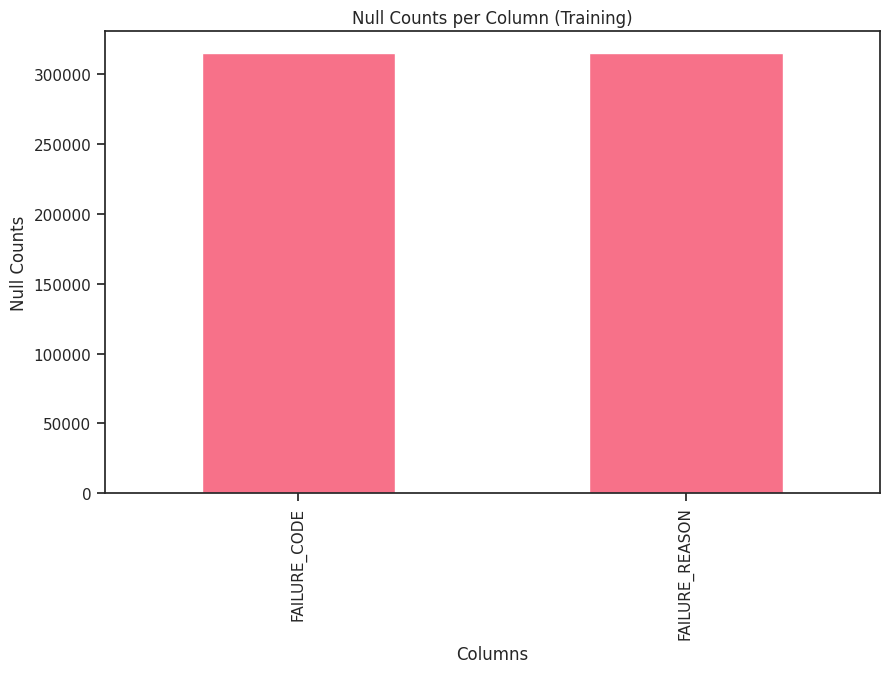

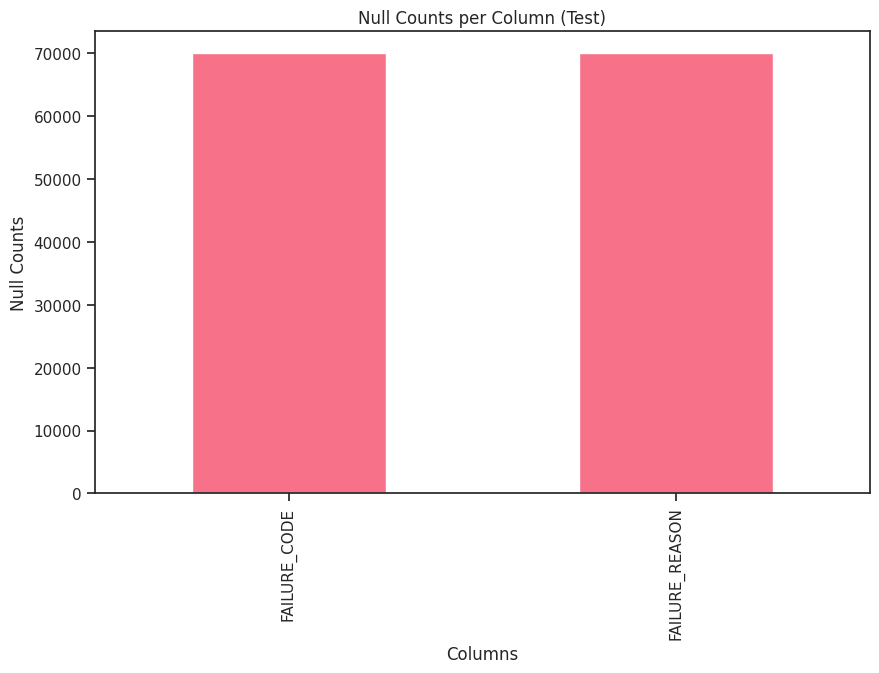

In [86]:
# Count the number of null values per column
null_counts_train = merged_train_df.isnull().sum()
null_counts_test = merged_test_df.isnull().sum()

print(f"Number of columns with null data in training set: {len(null_counts_train[null_counts_train > 0].tolist())}")
print(f"Number of columns with null data in test set: {len(null_counts_test[null_counts_test > 0].tolist())}")

# Plot null counts for training set
plt.figure(figsize=(10, 6))
null_counts_train[null_counts_train > 0].plot(kind='bar')
plt.title('Null Counts per Column (Training)')
plt.xlabel('Columns')
plt.ylabel('Null Counts')
plt.show()

# Plot null counts for test set
plt.figure(figsize=(10, 6))
null_counts_test[null_counts_test > 0].plot(kind='bar')
plt.title('Null Counts per Column (Test)')
plt.xlabel('Columns')
plt.ylabel('Null Counts')
plt.show()

Number of columns with null data in training set: 2
Number of columns with null data in test set: 2


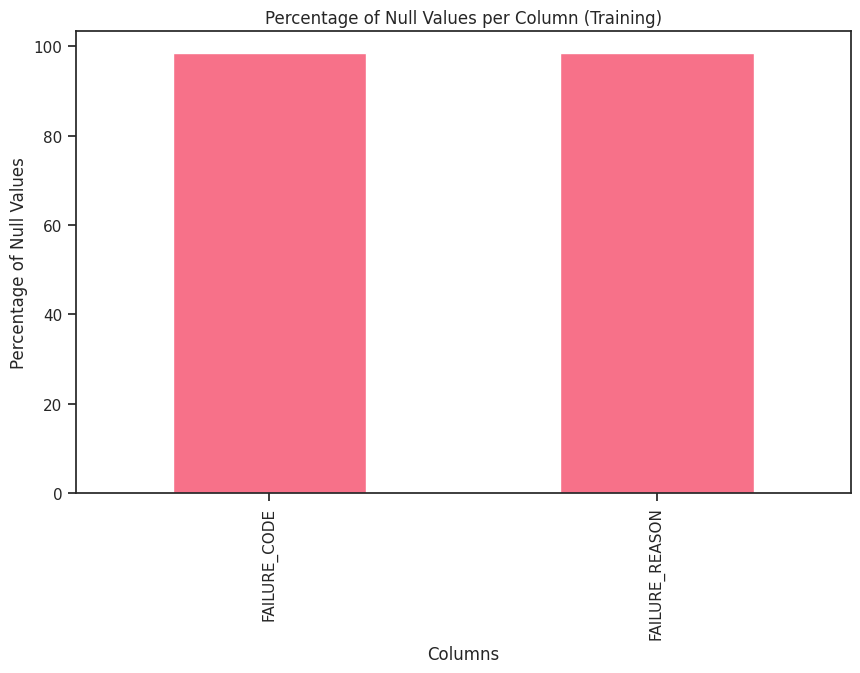

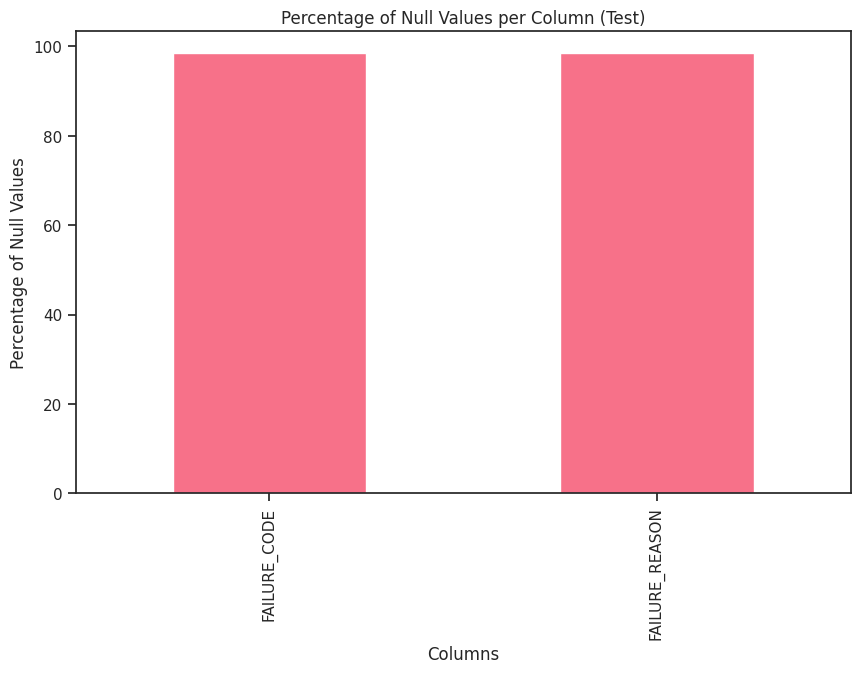

In [87]:
# Calculate the percentage of null values per column
null_percentage_train = (merged_train_df.isnull().sum() / len(merged_train_df)) * 100
null_percentage_test = (merged_test_df.isnull().sum() / len(merged_test_df)) * 100

# Filter to only show columns with null values
null_percentage_train_filtered = null_percentage_train[null_percentage_train > 0]
null_percentage_test_filtered = null_percentage_test[null_percentage_test > 0]

print(f"Number of columns with null data in training set: {len(null_percentage_train_filtered)}")
print(f"Number of columns with null data in test set: {len(null_percentage_test_filtered)}")

# Plot percentage of null values for training set
plt.figure(figsize=(10, 6))
null_percentage_train_filtered.plot(kind='bar')
plt.title('Percentage of Null Values per Column (Training)')
plt.xlabel('Columns')
plt.ylabel('Percentage of Null Values')
plt.show()

# Plot percentage of null values for test set
plt.figure(figsize=(10, 6))
null_percentage_test_filtered.plot(kind='bar')
plt.title('Percentage of Null Values per Column (Test)')
plt.xlabel('Columns')
plt.ylabel('Percentage of Null Values')
plt.show()


## Add Additional Columns


In [88]:
merged_train_df['FAILURE'] = np.where(merged_train_df['FAILURE_CODE'].isna(), 0, 1)
merged_test_df['FAILURE'] = np.where(merged_test_df['FAILURE_CODE'].isna(), 0, 1)
merged_test_df['DISTANCE_FROM_TERMINAL'] = np.sqrt((merged_test_df.x_customer_id - merged_test_df.x_terminal_id)**2 + (merged_test_df.y_customer_id - merged_test_df.y_terminal__id)**2)['DISTANCE_FROM_TERMINAL'] = np.sqrt((merged_test_df.x_customer_id - merged_test_df.x_terminal_id)**2 + (merged_test_df.y_customer_id - merged_test_df.y_terminal__id)**2)
merged_train_df['DISTANCE_FROM_TERMINAL'] = np.sqrt((merged_train_df.x_customer_id - merged_train_df.x_terminal_id)**2 + (merged_train_df.y_customer_id - merged_train_df.y_terminal__id)**2)['DISTANCE_FROM_TERMINAL'] = np.sqrt((merged_train_df.x_customer_id - merged_train_df.x_terminal_id)**2 + (merged_train_df.y_customer_id - merged_train_df.y_terminal__id)**2)

## Drop Failure Columns

In [89]:
merged_test_df = merged_test_df.drop(['FAILURE_CODE', 'FAILURE_REASON'], axis=1)
merged_train_df = merged_train_df.drop(['FAILURE_CODE', 'FAILURE_REASON'], axis=1)

# 4. Visualize Data

In [90]:
# dataset_report = sw.analyze(merged_train_df, "TX_AMOUNT")
# dataset_report.show_notebook(layout='vertical')

# 5. Manipulate Data
## Combine Data for Simultaneous Preprocessing

In [91]:
# Array of Ids for submission
testIds = merged_test_df.index

# Combine train and test data for simultaneous data preparation
data = pd.concat([merged_train_df.drop('TX_FRAUD', axis=1), merged_test_df.drop('ID_JOIN', axis=1)], keys=['train', 'test'])

display(data.shape)

(391070, 43)

## View Stats on the Data

In [92]:
data.describe()

,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TRANSACTION_GOODS_AND_SERVICES_AMOUNT,TRANSACTION_CASHBACK_AMOUNT,MCC_CODE,ANNUAL_TURNOVER_CARD,ANNUAL_TURNOVER,AVERAGE_TICKET_SALE_AMOUNT,PAYMENT_PERCENTAGE_FACE_TO_FACE,...,DELIVERY_SAME_DAYS_PERCENTAGE,DELIVERY_WEEK_ONE_PERCENTAGE,DELIVERY_WEEK_TWO_PERCENTAGE,DELIVERY_OVER_TWO_WEEKS_PERCENTAGE,x_customer_id,y_customer_id,x_terminal_id,y_terminal__id,FAILURE,DISTANCE_FROM_TERMINAL
count,3.910700e+05,3.910700e+05,391070.000000,391070.000000,391070.000000,391070.000000,3.910700e+05,3.910700e+05,391070.000000,391070.000000,...,391070.000000,391070.000000,391070.000000,391070.000000,391070.000000,391070.000000,391070.000000,391070.000000,391070.000000,391070.000000
mean,4.993749e+15,4.998320e+07,52.865442,52.619176,0.246266,6350.010816,3.727474e+07,5.263657e+07,308.207086,62.199253,...,24.161876,25.436369,24.023203,26.378551,50.056476,50.309453,50.048116,50.304095,0.016153,3.308733
std,2.883843e+15,2.871898e+07,29.183151,29.070054,1.508761,1561.167272,1.062456e+08,1.464516e+08,1746.120105,19.143948,...,3.722919,6.798968,4.166866,5.125055,28.888256,28.972194,28.855450,28.913499,0.126064,1.190392
min,1.495851e+11,6.454200e+04,0.000000,0.000000,0.000000,742.000000,3.000000e+01,4.600000e+01,0.000000,6.000000,...,5.000000,20.000000,0.000000,4.000000,0.007194,0.000331,0.007245,0.007370,0.000000,0.000000
25%,2.525285e+15,2.504898e+07,28.570000,28.400000,0.000000,5441.000000,1.498040e+05,2.214050e+05,66.000000,46.000000,...,22.000000,22.000000,22.000000,23.000000,24.886942,25.095469,25.018001,25.052059,0.000000,2.464932
50%,4.962487e+15,4.965185e+07,52.220000,51.950000,0.000000,5977.000000,3.105250e+05,4.676450e+05,105.000000,61.000000,...,24.000000,25.000000,24.000000,26.000000,50.420727,50.320145,50.067702,50.352782,0.000000,3.506549
75%,7.477224e+15,7.435430e+07,75.960000,75.580000,0.000000,7641.000000,5.279335e+05,7.115240e+05,155.000000,76.000000,...,27.000000,27.000000,27.000000,30.000000,74.906795,75.633724,74.800362,75.799002,0.000000,4.316751
max,9.999981e+15,9.999799e+07,596.190000,596.190000,79.680000,9950.000000,1.030432e+09,1.163046e+09,45822.000000,100.000000,...,29.000000,84.000000,29.000000,45.000000,99.997455,99.999901,99.994897,99.997795,1.000000,4.999990


## Convert Dates to Datetimes

In [93]:
# Convert transaction timestamp to datetime
data['TX_DATE'] = pd.to_datetime(data['TX_TS'])
data = data.drop(['TX_TS'], axis=1)

def card_expiry_to_date(expiry_str):
    parts = expiry_str.split('/')
    month = int(parts[0])
    year = int(parts[1])
    if len(str(year)) == 2:
        year += 2000
    last_day = calendar.monthrange(year, month)[1]
    return datetime(year, month, last_day)

# Apply the conversion to CARD_EXPIRY_DATE
data['CARD_EXPIRY_DATE'] = data['CARD_EXPIRY_DATE'].apply(card_expiry_to_date)

# List of date columns
dates = ['FOUNDATION_DATE', 'ACTIVE_FROM', 'TRADING_FROM', 'CARD_EXPIRY_DATE']

# Ensure all date columns are in datetime format
for col in dates:
    data[col] = pd.to_datetime(data[col])

## Convert Datetimes to Useful Data

In [94]:
# Extract features from the transaction date
def categorize_time_of_day(hour):
    if hour < 6:
        return 'Night'
    elif hour < 12:
        return 'Morning'
    elif hour <18:
        return 'Afternoon'
    else:
        return 'Evening'
    
data['transaction_year'] = data['TX_DATE'].dt.year
data['transaction_month_sin'] = np.sin(2 * np.pi * data['TX_DATE'].dt.month / 12)
data['transaction_is_on_weekend'] = data['TX_DATE'].dt.dayofweek >= 5
data['transaction_time_of_day'] = data['TX_DATE'].dt.hour.apply(categorize_time_of_day)

In [95]:
# Remove timezone info (make all dates timezone-naive)
data['TX_DATE'] = pd.to_datetime(data['TX_DATE']).dt.tz_localize(None)
data['CARD_EXPIRY_DATE'] = pd.to_datetime(data['CARD_EXPIRY_DATE']).dt.tz_localize(None)
data['FOUNDATION_DATE'] = pd.to_datetime(data['FOUNDATION_DATE']).dt.tz_localize(None)
data['ACTIVE_FROM'] = pd.to_datetime(data['ACTIVE_FROM']).dt.tz_localize(None)
data['TRADING_FROM'] = pd.to_datetime(data['TRADING_FROM']).dt.tz_localize(None)

# Get time between transaction and other dates
data['days_until_expiry'] = (data['CARD_EXPIRY_DATE'] - data['TX_DATE']).dt.days
data['days_until_expiry'] = data['days_until_expiry'].apply(lambda x: max(x, 0)) # Convert negative values to 0

data['days_since_company_founded'] = (data['FOUNDATION_DATE'] - data['TX_DATE']).dt.days
data['days_since_company_founded'] = data['days_since_company_founded'].apply(lambda x: max(x, 0))
                                           
data['days_since_company_active'] = (data['ACTIVE_FROM'] - data['TX_DATE']).dt.days
data['days_since_company_active'] = data['days_since_company_active'].apply(lambda x: max(x, 0))
                                           
data['days_since_company_trading'] = (data['TRADING_FROM'] - data['TX_DATE']).dt.days
data['days_since_company_trading'] = data['days_since_company_trading'].apply(lambda x: max(x, 0))

## Drop Original Date Columns

In [96]:
data.drop(columns=['CARD_EXPIRY_DATE', 'FOUNDATION_DATE', 'ACTIVE_FROM', 'TRADING_FROM', 'TX_DATE'], inplace=True)

## Drop IDs

In [97]:
data.drop(columns=['CUSTOMER_ID','TERMINAL_ID','MERCHANT_ID','CARD_DATA','LEGAL_NAME'], inplace=True)

## Splitting the Dataset into Categorical and Numerical Features

In [98]:
numerical_cols = data.select_dtypes(include=['int32', 'int64', 'float64'])
categorical_cols = data.select_dtypes(include=['object', 'bool'])
print('Numerical columns:')
print(numerical_cols.columns)
print('Categorical columns:')
print(categorical_cols.columns)
print(f"Total columns in dataframe: ${len(data.columns)}")
print(f"Total numerical and categorical columns: ${len(numerical_cols.columns) + len(categorical_cols.columns)}")

Numerical columns:
Index(['TX_AMOUNT', 'TRANSACTION_GOODS_AND_SERVICES_AMOUNT',
       'TRANSACTION_CASHBACK_AMOUNT', 'MCC_CODE', 'ANNUAL_TURNOVER_CARD',
       'ANNUAL_TURNOVER', 'AVERAGE_TICKET_SALE_AMOUNT',
       'PAYMENT_PERCENTAGE_FACE_TO_FACE', 'PAYMENT_PERCENTAGE_ECOM',
       'PAYMENT_PERCENTAGE_MOTO', 'DEPOSIT_REQUIRED_PERCENTAGE',
       'DEPOSIT_PERCENTAGE', 'DELIVERY_SAME_DAYS_PERCENTAGE',
       'DELIVERY_WEEK_ONE_PERCENTAGE', 'DELIVERY_WEEK_TWO_PERCENTAGE',
       'DELIVERY_OVER_TWO_WEEKS_PERCENTAGE', 'x_customer_id', 'y_customer_id',
       'x_terminal_id', 'y_terminal__id', 'FAILURE', 'DISTANCE_FROM_TERMINAL',
       'transaction_year', 'transaction_month_sin', 'days_until_expiry',
       'days_since_company_founded', 'days_since_company_active',
       'days_since_company_trading'],
      dtype='object')
Categorical columns:
Index(['CARD_BRAND', 'TRANSACTION_TYPE', 'TRANSACTION_STATUS',
       'TRANSACTION_CURRENCY', 'CARD_COUNTRY_CODE', 'IS_RECURRING_TRANSACTION',
  

## Get Unique Values Per Categorical Column

In [99]:
# Get the number of unique values in each categorical column
unique_values_per_column = categorical_cols.nunique()

# Display the result
print(unique_values_per_column)

CARD_BRAND                    4
TRANSACTION_TYPE              4
TRANSACTION_STATUS            4
TRANSACTION_CURRENCY         11
CARD_COUNTRY_CODE            14
IS_RECURRING_TRANSACTION      2
ACQUIRER_ID                   6
CARDHOLDER_AUTH_METHOD        7
BUSINESS_TYPE                 4
TAX_EXCEMPT_INDICATOR         2
OUTLET_TYPE                   3
transaction_is_on_weekend     2
transaction_time_of_day       4
dtype: int64


## Encode Categorical Data

In [100]:
#data = pd.get_dummies(data)
#display(data.info())
le_card_brand = LabelEncoder()
le_transaction_type = LabelEncoder()
le_transaction_status = LabelEncoder()
le_transaction_currency = LabelEncoder()
le_card_country_code = LabelEncoder()
le_is_recurring_transaction = LabelEncoder()
le_acquirer_id = LabelEncoder()
le_cardholder_auth_method = LabelEncoder()
le_business_type = LabelEncoder()
le_tax_excempt_indicator = LabelEncoder()
le_outlet_type = LabelEncoder()
le_is_on_weekend = LabelEncoder()
le_time_of_day = LabelEncoder()

data['CARD_BRAND'] = le_card_brand.fit_transform(data['CARD_BRAND'])
data['TRANSACTION_TYPE'] = le_transaction_type.fit_transform(data['TRANSACTION_TYPE'])
data['TRANSACTION_STATUS'] = le_transaction_status.fit_transform(data['TRANSACTION_STATUS'])
data['TRANSACTION_CURRENCY'] = le_transaction_currency.fit_transform(data['TRANSACTION_CURRENCY'])
data['CARD_COUNTRY_CODE'] = le_card_country_code.fit_transform(data['CARD_COUNTRY_CODE'])
data['IS_RECURRING_TRANSACTION'] = le_is_recurring_transaction.fit_transform(data['IS_RECURRING_TRANSACTION'])
data['ACQUIRER_ID'] = le_acquirer_id.fit_transform(data['ACQUIRER_ID'])
data['CARDHOLDER_AUTH_METHOD'] = le_cardholder_auth_method.fit_transform(data['CARDHOLDER_AUTH_METHOD'])
data['BUSINESS_TYPE'] = le_business_type.fit_transform(data['BUSINESS_TYPE'])
data['TAX_EXCEMPT_INDICATOR'] = le_tax_excempt_indicator.fit_transform(data['TAX_EXCEMPT_INDICATOR'])
data['OUTLET_TYPE'] = le_outlet_type.fit_transform(data['OUTLET_TYPE'])
data['transaction_is_on_weekend'] = le_is_on_weekend.fit_transform(data['transaction_is_on_weekend'])
data['transaction_time_of_day'] = le_time_of_day.fit_transform(data['transaction_time_of_day'])

# 6. View Manipulated Data

In [101]:
display(data.shape)
display(data.info())
display(data.head())
display(data.describe())

(391070, 41)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 391070 entries, ('train', 633693) to ('test', 71137)
Data columns (total 41 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   TX_AMOUNT                              391070 non-null  float64
 1   TRANSACTION_GOODS_AND_SERVICES_AMOUNT  391070 non-null  float64
 2   TRANSACTION_CASHBACK_AMOUNT            391070 non-null  float64
 3   CARD_BRAND                             391070 non-null  int64  
 4   TRANSACTION_TYPE                       391070 non-null  int64  
 5   TRANSACTION_STATUS                     391070 non-null  int64  
 6   TRANSACTION_CURRENCY                   391070 non-null  int64  
 7   CARD_COUNTRY_CODE                      391070 non-null  int64  
 8   IS_RECURRING_TRANSACTION               391070 non-null  int64  
 9   ACQUIRER_ID                            391070 non-null  int64  
 10  CARDHOLDER_AUTH_METHOD         

None

TX_AMOUNT  TRANSACTION_GOODS_AND_SERVICES_AMOUNT  \
train 633693      71.47                                  71.47   
      718402      24.99                                  24.99   
      28169       27.10                                  27.10   
      984084      46.30                                  46.30   
      485147      97.14                                  97.14   

              TRANSACTION_CASHBACK_AMOUNT  CARD_BRAND  TRANSACTION_TYPE  \
train 633693                          0.0           3                 1   
      718402                          0.0           2                 1   
      28169                           0.0           0                 1   
      984084                          0.0           3                 1   
      485147                          0.0           3                 1   

              TRANSACTION_STATUS  TRANSACTION_CURRENCY  CARD_COUNTRY_CODE  \
train 633693                   3                     5                 13   
      718402                   3                     4                  1   
      28169                    3                    10                  5   
      984084                   3                    10                  0   
      485147                   3                     5                 13   

              IS_RECURRING_TRANSACTION  ACQUIRER_ID  ...  FAILURE  \
train 633693                         1            1  ...        0   
      718402                         1            2  ...        0   
      28169                          1            4  ...        0   
      984084                         1            0  ...        0   
      485147                         1            1  ...        0   

              DISTANCE_FROM_TERMINAL  transaction_year  transaction_month_sin  \
train 633693                3.784183              2021               0.500000   
      718402                1.780519              2021               0.866025   
      28169                 3.317118              2021               0.500000   
      984084                2.127285              2021               0.866025   
      485147                3.857880              2021               0.866025   

              transaction_is_on_weekend  transaction_time_of_day  \
train 633693                          0                        1   
      718402                          0                        1   
      28169                           0                        0   
      984084                          0                        0   
      485147                          1                        3   

              days_until_expiry  days_since_company_founded  \
train 633693                611                           0   
      718402                434                           0   
      28169                 599                           0   
      984084                276                           0   
      485147                604                           0   

              days_since_company_active  days_since_company_trading  
train 633693                          0                           0  
      718402                          0                           0  
      28169                           0                           0  
      984084                          0                           0  
      485147                          0                           0  

[5 rows x 41 columns]

,TX_AMOUNT,TRANSACTION_GOODS_AND_SERVICES_AMOUNT,TRANSACTION_CASHBACK_AMOUNT,CARD_BRAND,TRANSACTION_TYPE,TRANSACTION_STATUS,TRANSACTION_CURRENCY,CARD_COUNTRY_CODE,IS_RECURRING_TRANSACTION,ACQUIRER_ID,...,FAILURE,DISTANCE_FROM_TERMINAL,transaction_year,transaction_month_sin,transaction_is_on_weekend,transaction_time_of_day,days_until_expiry,days_since_company_founded,days_since_company_active,days_since_company_trading
count,391070.000000,391070.000000,391070.000000,391070.000000,391070.000000,391070.000000,391070.000000,391070.000000,391070.000000,391070.000000,...,391070.000000,391070.000000,391070.000000,3.910700e+05,391070.000000,391070.000000,391070.000000,391070.000000,391070.00000,391070.000000
mean,52.865442,52.619176,0.246266,2.383394,1.009131,2.792293,5.336359,8.920083,0.835380,1.272199,...,0.016153,3.308733,2021.000003,-4.263357e-03,0.287363,1.503897,461.294876,24.608510,26.16594,26.675830
std,29.183151,29.070054,1.508761,0.742499,0.339634,0.634749,3.242565,4.329139,0.370838,1.018323,...,0.126064,1.190392,0.001599,6.670816e-01,0.452533,1.117074,203.986300,88.535845,92.46982,93.731251
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2021.000000,-1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,28.570000,28.400000,0.000000,2.000000,1.000000,3.000000,3.000000,5.000000,1.000000,1.000000,...,0.000000,2.464932,2021.000000,-5.000000e-01,0.000000,1.000000,285.000000,0.000000,0.00000,0.000000
50%,52.220000,51.950000,0.000000,3.000000,1.000000,3.000000,5.000000,10.000000,1.000000,1.000000,...,0.000000,3.506549,2021.000000,-2.449294e-16,0.000000,2.000000,461.000000,0.000000,0.00000,0.000000
75%,75.960000,75.580000,0.000000,3.000000,1.000000,3.000000,10.000000,13.000000,1.000000,2.000000,...,0.000000,4.316751,2021.000000,5.000000e-01,1.000000,3.000000,637.000000,0.000000,0.00000,0.000000
max,596.190000,596.190000,79.680000,3.000000,3.000000,3.000000,10.000000,13.000000,1.000000,5.000000,...,1.000000,4.999990,2022.000000,1.000000e+00,1.000000,3.000000,829.000000,666.000000,685.00000,689.000000


# 7. Split Data
## Split out Combined Train and Test Data

In [102]:
x_test_final = data.loc['test']
x_total = data.loc['train']
y_total = merged_train_df[['TX_FRAUD']]
display(x_test_final.shape)
display(x_total.shape)
display(y_total.shape)

(71138, 41)

(319932, 41)

(319932, 1)

## Split Train Data Into Train and Test for Validation

In [103]:
x_train, x_test, y_train, y_test = train_test_split(
    x_total, y_total, test_size=0.1, random_state=0)
print("x_train:")
display(x_train.head())
print("x_test:")
display(x_test.head())
print("y_train")
display(y_train.head())
print("y_test")
display(y_test.head())

x_train:


,TX_AMOUNT,TRANSACTION_GOODS_AND_SERVICES_AMOUNT,TRANSACTION_CASHBACK_AMOUNT,CARD_BRAND,TRANSACTION_TYPE,TRANSACTION_STATUS,TRANSACTION_CURRENCY,CARD_COUNTRY_CODE,IS_RECURRING_TRANSACTION,ACQUIRER_ID,...,FAILURE,DISTANCE_FROM_TERMINAL,transaction_year,transaction_month_sin,transaction_is_on_weekend,transaction_time_of_day,days_until_expiry,days_since_company_founded,days_since_company_active,days_since_company_trading
944571,98.16,98.16,0.0,3,1,1,10,3,1,2,...,0,3.325574,2021,1.224647e-16,1,1,753,0,0,0
839788,60.44,60.44,0.0,2,1,3,4,10,1,2,...,0,2.982278,2021,1.000000e+00,0,0,211,0,0,0
1047659,5.07,5.07,0.0,2,1,3,10,12,1,2,...,0,3.073526,2021,-5.000000e-01,0,2,277,0,0,0
863658,94.17,94.17,0.0,2,1,3,4,1,1,0,...,0,3.977880,2021,-1.000000e+00,0,2,790,0,0,0
265472,67.12,67.12,0.0,3,1,3,5,8,1,1,...,0,1.802170,2021,1.000000e+00,0,3,273,281,310,314


x_test:


,TX_AMOUNT,TRANSACTION_GOODS_AND_SERVICES_AMOUNT,TRANSACTION_CASHBACK_AMOUNT,CARD_BRAND,TRANSACTION_TYPE,TRANSACTION_STATUS,TRANSACTION_CURRENCY,CARD_COUNTRY_CODE,IS_RECURRING_TRANSACTION,ACQUIRER_ID,...,FAILURE,DISTANCE_FROM_TERMINAL,transaction_year,transaction_month_sin,transaction_is_on_weekend,transaction_time_of_day,days_until_expiry,days_since_company_founded,days_since_company_active,days_since_company_trading
754082,13.46,13.46,0.0,0,1,3,4,5,1,2,...,0,4.330379,2021,-0.5,1,3,592,0,0,0
136220,10.09,10.09,0.0,1,1,3,1,13,1,2,...,0,4.492109,2021,0.5,1,0,326,258,282,284
170594,33.63,33.63,0.0,3,1,3,4,7,1,2,...,0,4.954299,2021,0.5,0,1,694,0,0,0
137385,14.99,14.99,0.0,3,1,3,2,13,1,2,...,0,3.957548,2021,-0.5,0,3,446,352,353,353
356607,64.39,64.39,0.0,3,1,1,5,8,1,3,...,0,4.256882,2021,0.5,0,1,352,0,0,0


y_train


,TX_FRAUD
944571,0
839788,0
1047659,0
863658,0
265472,0


y_test


,TX_FRAUD
754082,0
136220,0
170594,0
137385,0
356607,0


# 8. Define Model

[Text(0.9184057185228991, 0.990909090909091, 'x[0] <= 133.275\ngini = 0.051\nsamples = 287938\nvalue = [280365, 7573]'),
 Text(0.8472792348512886, 0.9727272727272728, 'x[37] <= 54.5\ngini = 0.049\nsamples = 287571\nvalue = [280360, 7211]'),
 Text(0.8471261040092556, 0.9545454545454546, 'gini = 0.0\nsamples = 138\nvalue = [0, 138]'),
 Text(0.8474323656933216, 0.9545454545454546, 'x[4] <= 1.5\ngini = 0.048\nsamples = 287433\nvalue = [280360, 7073]'),
 Text(0.7184651758752806, 0.9363636363636364, 'x[29] <= 99.512\ngini = 0.046\nsamples = 273389\nvalue = [266972, 6417]'),
 Text(0.52678164912274, 0.9181818181818182, 'x[1] <= 126.995\ngini = 0.045\nsamples = 272657\nvalue = [266320, 6337]'),
 Text(0.15648219433950217, 0.9, 'x[30] <= 0.309\ngini = 0.045\nsamples = 272620\nvalue = [266298, 6322]'),
 Text(0.0027264467890091497, 0.8818181818181818, 'x[30] <= 0.275\ngini = 0.189\nsamples = 689\nvalue = [616, 73]'),
 Text(0.0025733159469761655, 0.8636363636363636, 'x[0] <= 112.745\ngini = 0.049\ns

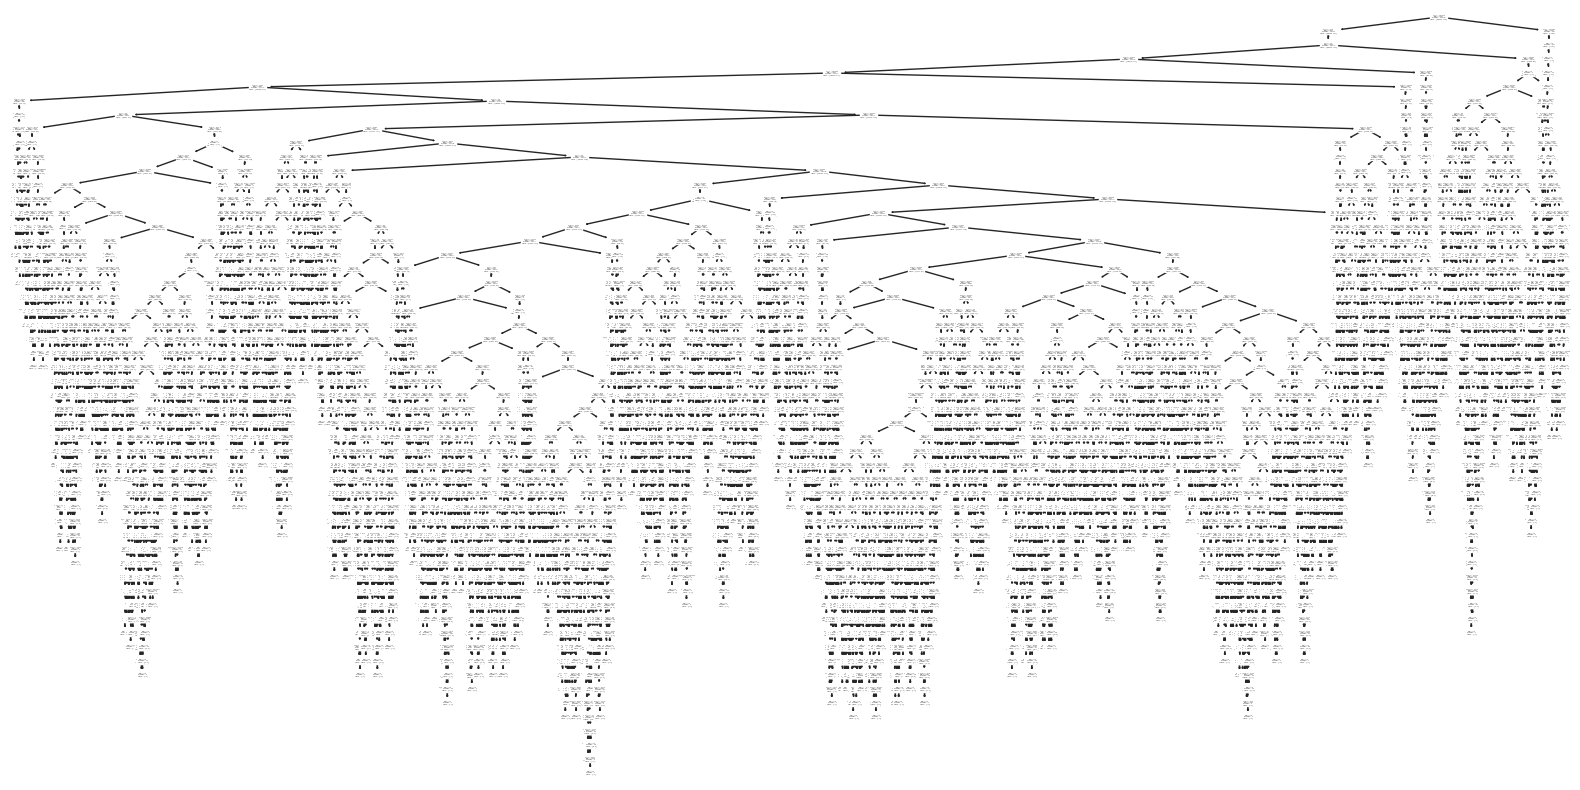

In [105]:
dtree = DecisionTreeClassifier()
dtree = dtree.fit(x_train, y_train)

tree.plot_tree(dtree)

# 9. Evaluate Model

In [113]:
y_pred = dtree.predict(x_test)
print("Confusion Matrix: ", confusion_matrix(y_test, y_pred)) 
print("Accuracy : ", accuracy_score(y_test, y_pred)*100) 
print("Report : ", classification_report(y_test, y_pred))

Confusion Matrix:  [[30418   745]
 [  530   301]]
Accuracy :  96.01487778958555
Report :                precision    recall  f1-score   support

           0       0.98      0.98      0.98     31163
           1       0.29      0.36      0.32       831

    accuracy                           0.96     31994
   macro avg       0.64      0.67      0.65     31994
weighted avg       0.96      0.96      0.96     31994

